### Итоговая работа
### 12448/3 ИНЖДАН МГТУ им. Н.Э. Баумана
### Инженер данных (Data engineer)
### Сайфуллин Руслан Рафитович

## КЛАССИФИКАЦИЯ ГОСКОНТРАКТОВ ПО ОБЪЕКТАМ ЗАКУПКИ

#### Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

Группы могут быть следующими:

1.	Строительно-монтажные работы (СМР)
2.	Проектно-изыскательские работы (ПИР)
3.	Строительный надзор
4.	Подключение коммуникаций
5.	Прочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
- Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
- Проектно-изыскательские работы (ПИР) - 41.1, 71.1
- Подключение коммуникаций - 43.22
- Строительный надзор – четкой группы нет.


Проблема: Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить в нужную группу.

Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован естественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.
На основе этого на входе данные о контрактах. На выходе необходимо получить группу для каждого контракта.

Иногда контракт может относиться одновременно в несколько групп.

В приложении ниже пример нескольких контрактов, у которых неверно проставлен ОКПД-2.

## Решаем задачу классификации

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
columns = ['object_name', 'object_code', 'cost', 'contract_execution_days']
dtypes = {'object_name': str,
          'object_code': str, 
          'cost':lambda x: pd.to_numeric(x, errors="coerce"), 
          'contract_execution_days': lambda x: pd.to_numeric(x, errors="coerce"),
          'cluster': int}


In [3]:
df = pd.read_csv('datasets/dataset_nlp_process.csv', sep=';', low_memory=False, on_bad_lines='skip')
df['object_name']  = df['object_name'].astype('string')
df['object_code']  = df['object_code'].astype('string')
df.shape

(900153, 8)

In [4]:
df.dtypes

id                                  int64
contract_number                     int64
object_name                string[python]
object_code                string[python]
cost                              float64
contract_execution_days             int64
data                               object
data_final                         object
dtype: object

In [5]:
#Делаем разбивку по группам на основании номеров ОКПД-2
import re 

def match(templ, value):
    try:
      return re.search(f'^{templ}.', value) 
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        return False
    
def get_group(value):    
    if (match('41', value) or match('42', value) or match('43', value)) and  value not in ('43.9, 42.9, 42.2, 43.2', '41.1', '71.1', '43.2'):  
        return 'Строительно-монтажные работы'
    elif value in ('41.1', '71.1'):  
        return 'Проектно-изыскательские работы'
    elif value in ('43.2'):  
        return 'Подключение коммуникаций'
    elif value in ('43.9', '42.9', '42.2'):  
        return 'Строительный надзор'
    else:
        return 'Прочие'

In [6]:
df['group'] = df['object_code'].apply(lambda x: get_group(x))
df.head()

,id,contract_number,object_name,object_code,cost,contract_execution_days,data,data_final,group
0,137439,2590407717221000153,Работы строительные специализированные,43.9,539265.60,29,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительно-монтажные работы
1,137528,2590421285821000134,Работы строительные специализированные,43.9,2299469.98,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительно-монтажные работы
2,137529,2590421285821000135,Работы строительные специализированные,43.9,1898111.58,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительно-монтажные работы
3,137827,2590500335021000676,Работы строительные специализированные,43.3,341914.00,199,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительно-монтажные работы
4,138113,2590615606021000060,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,"['услуги', 'в', 'области', 'архитектуры', 'и',...","['услуг', 'област', 'архитектур', 'проектирова...",Проектно-изыскательские работы


In [7]:
from sklearn.model_selection import train_test_split

df['price_per_day'] = df['cost'] / df['contract_execution_days']
#X =  df[['price_per_day']]
X = df.drop(['object_name', 'object_code', 'price_per_day', 'contract_execution_days', 'data', 'group'], axis=1)
#X = df[['cost', 'contract_execution_days']]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=1700, min_df=5, max_df=0.7)

#df = df.sample(100000)
X = df['data_final']
tfidf_X = tfidf.fit_transform(X).toarray()
tfidf_X.shape

(900153, 14)

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['group'])
y = le.transform(df['group'])
y

array([2, 2, 2, ..., 2, 2, 2])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, y, test_size=0.3)
print(X_train.shape, X_test.shape)

(630107, 14) (270046, 14)


In [351]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(tfidf_X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


### SVC Машина опорных векторов

In [352]:
from sklearn.svm import SVC
model_svc = SVC(C=100)
model_svc.fit(X_train, y_train)

y_pred = model_svc.predict(X_test)
y_pred

In [ ]:
model_svc.score(X_test_scaled, y_test)

0.6634

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#pred = model_svc.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[    0,     0,     0],
       [    0,  4278,     0],
       [ 5574,   246, 19902]], dtype=int64)

In [ ]:
pred = model_svc.predict(X_test)
print(metrics.classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.95      1.00      0.97      4278
           2       1.00      0.77      0.87     25722

    accuracy                           0.81     30000
   macro avg       0.65      0.59      0.61     30000
weighted avg       0.99      0.81      0.89     30000



### Логистическая регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2", "elasticnet"]}
grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'penalty': ['l1', 'l2', 'elasticnet']}

In [ ]:
model_lr = LogisticRegression(multi_class='ovr')
search_model = GridSearchCV(model_lr, grid, cv=10)
search_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(multi_class='ovr'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [ ]:
search_model.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [ ]:
model = search_model.best_estimator_

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(C=0.001, multi_class='ovr')

In [ ]:
model.predict(X_test)

array([2, 2, 2, ..., 1, 2, 2])

In [ ]:
model.score(X_test_scaled, y_test)

0.806

In [ ]:
pred = model.predict(X_test)
confusion_matrix(pred, y_test)

array([[    0,     0,     0],
       [    0,  4278,     0],
       [ 5574,   246, 19902]], dtype=int64)

In [ ]:
# набор метрик для оценки качества модели
pred = model.predict(X_test)
print(metrics.classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.95      1.00      0.97      4278
           2       1.00      0.77      0.87     25722

    accuracy                           0.81     30000
   macro avg       0.65      0.59      0.61     30000
weighted avg       0.99      0.81      0.89     30000



### Метод ближайших соседей KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3 ).fit(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

0.7323666666666667

In [ ]:
pred = model.predict(X_test)
confusion_matrix(pred, y_test)

array([[ 5574,     0,  7783],
       [    0,  4278,     0],
       [    0,   246, 12119]], dtype=int64)

In [ ]:
from sklearn.metrics import confusion_matrix
print(metrics.classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.42      0.59     13357
           1       0.95      1.00      0.97      4278
           2       0.61      0.98      0.75     12365

    accuracy                           0.73     30000
   macro avg       0.85      0.80      0.77     30000
weighted avg       0.83      0.73      0.71     30000



### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB().fit(X_train, y_train)

In [ ]:
model_nb.score(X_test_scaled, y_test)

0.7323666666666667

### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=5, min_samples_leaf=5 ).fit(X_train, y_train)

In [ ]:
model_dt.score(X_test_scaled, y_test)

0.806

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
model_rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0).fit(X_train, y_train) 

In [ ]:
model_rf.score(X_test_scaled, y_test)

0.806

### Построим нейронную сеть для классификации

In [ ]:
! pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
model_nn = tf.keras.Sequential([
tf.keras.layers.Dense(14, activation='sigmoid',name='fc1', input_shape=(14,)),
tf.keras.layers.Dense(14, activation='sigmoid',name='fc3', input_shape=(4,)),
tf.keras.layers.Dense(4, name='fc4', activation='softmax')])
model_nn.summary() 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 14)                210       
                                                                 
 fc3 (Dense)                 (None, 14)                210       
                                                                 
 fc4 (Dense)                 (None, 4)                 60        
                                                                 
Total params: 480 (1.88 KB)
Trainable params: 480 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import numpy as np
num_epochs = 10
history = model_nn.fit(X_train, y_train, epochs=num_epochs,  verbose=1)

Epoch 1/10
2188/2188 [==============================] - 2s 691us/step - loss: 0.5063 - accuracy: 0.7806
Epoch 2/10
2188/2188 [==============================] - 2s 720us/step - loss: 0.3385 - accuracy: 0.8085
Epoch 3/10
2188/2188 [==============================] - 2s 686us/step - loss: 0.3332 - accuracy: 0.8085
Epoch 4/10
2188/2188 [==============================] - 2s 690us/step - loss: 0.3322 - accuracy: 0.8085
Epoch 5/10
2188/2188 [==============================] - 2s 689us/step - loss: 0.3317 - accuracy: 0.8085
Epoch 6/10
2188/2188 [==============================] - 2s 689us/step - loss: 0.3315 - accuracy: 0.8085
Epoch 7/10
2188/2188 [==============================] - 2s 691us/step - loss: 0.3315 - accuracy: 0.8085
Epoch 8/10
2188/2188 [==============================] - 2s 691us/step - loss: 0.3312 - accuracy: 0.8085
Epoch 9/10
2188/2188 [==============================] - 2s 704us/step - loss: 0.3311 - accuracy: 0.8085
Epoch 10/10
2188/2188 [==============================] - 2s 710u

In [ ]:
results = model_nn.evaluate(X_test, y_test, verbose=1)
print('Test loss: {:.4f} Test Acc.: {:.4f}'.format(*results))

938/938 [==============================] - 1s 609us/step - loss: 0.3324 - accuracy: 0.8060
Test loss: 0.3324 Test Acc.: 0.8060


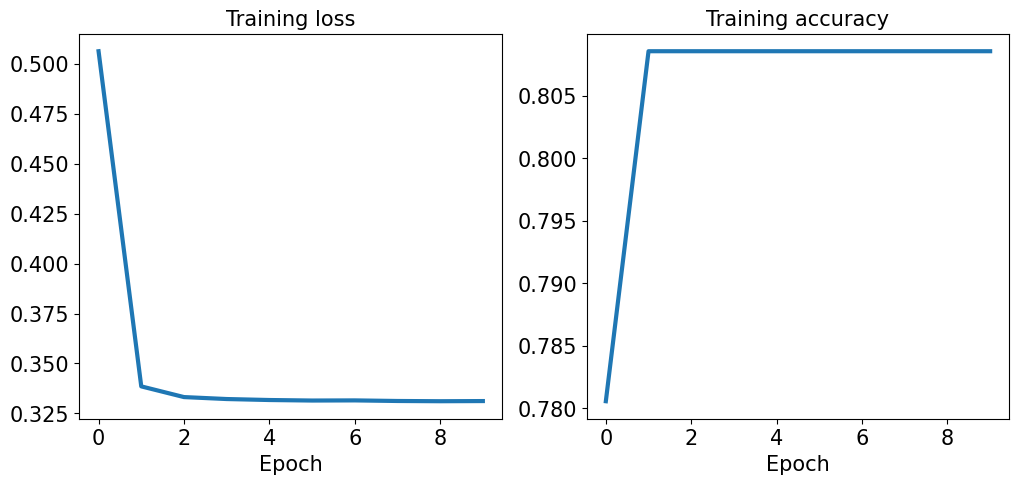

In [ ]:
import matplotlib.pyplot as plt
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Выводы о проделаной работе